# Class for Physio Data - Section Features

In [ ]:
from IPython.display import clear_output
from pivottablejs import pivot_ui
import skinematics as skin
import pandas as pd
import numpy as np
import sqlite3
import os

In [ ]:
def load_data_from_database(data_base_path='DataBase_Physio_with_nonEx.db'):
    '''
    Function to load the following data from data base:
        - subject IDs
        - exercise abbreviations
        - number of repetitions
        - sequence numbers
        - start times
        - stop times
        - csv-file name
    
    
    Parameters
    ----------
    data_base_path : string
        Path to data base.
    
    
    Returns
    -------
    DataFrame
        DataFrame with the listet information (see above).
    '''
    # Connect to an existing database
    conn = sqlite3.connect(data_base_path)
    cur = conn.cursor()

    # sql command to extract data
    query_sql = """
        SELECT e.subject_id,
        p.abbreviation,
        e.num_rep,
        r.sequence_num,
        r.start_time, r.stop_time,
        e.csv_file
        FROM subjects s
        INNER JOIN exercises e
        ON s.id = e.subject_id
        INNER JOIN paradigms p
        ON p.id = e.paradigm_id
        INNER JOIN repetitions r
        ON e.id = r.exercise_id
        """
    
    # get data from data base and close connection
    all_data_points_df = pd.read_sql_query(query_sql, conn)
    conn.close()
    
    return all_data_points_df

In [ ]:
def select_data_points_from_df(all_data_points_df,
                               subject_ids=-1,
                               subject_ids_complementary=[],
                               reps=-1,
                               abbrs=-1,
                               with_non_Ex=True,
                               sub_id_key='subject_id',
                               num_rep_key='num_rep',
                               abbreviation_key='abbreviation'):
    '''
    Function to select data points from a DataFrame based on subject IDs,
    number of repetitions and exercise abbreviations.
    
    
    Parameters
    ----------
    all_data_points_df : pandas DataFrame
        DataFrame with all data points.
    
    subject_ids : int or list
        Subject IDs to select (e.g. [1, 2, 3]).
        --> default -1: Select all subjects not in subject_ids_complementary.
        --> if subject_ids is an empty list: empty DataFrame is returned
        
    subject_ids_complementary : int or list
        If subject_ids is -1 --> select all subjects not in subject_ids_complementary.
        
    reps : int or list
        Repetition numbers to select (e.g. [5, 10]).
        --> default -1: Select all repetitions.
        
    abbrs : int or list
        Exercise abbreviations to select (e.g. ['RF', 'SA']).
        --> default -1: Select all exercise abbreviations.
    
    with_non_Ex : boolean
        If False --> omit non exercise data (data points with zero repetitions).
        
    sub_id_key : string
        Key of the DataFrame for subject IDs.
        
    num_rep_key : string
        Key of the DataFrame for repetition numbers.
        
    abbreviation_key : string
        Key of the DataFrame for exercise abbreviations.
    
    
    Returns
    -------
    DataFrame
        DataFrame with selected data points.
    '''
    
    data_points_df = all_data_points_df.copy()
    
    # check if subject_ids is an empty list --> return and empty DataFrame in this case
    if isinstance(subject_ids, list) and not subject_ids:
        return pd.DataFrame()
    
    # select the subject IDs
    # if subject_ids is -1 --> select data from all subjects that are NOT in subject_ids_complementary
    if subject_ids is -1:
        if not isinstance(subject_ids_complementary, list): # if not list --> make list
            subject_ids_complementary = [subject_ids_complementary]
        data_points_df = data_points_df.loc[~data_points_df[sub_id_key].isin(subject_ids_complementary)]
        
    elif subject_ids is not -1:
        if not isinstance(subject_ids, list): # if not list --> make list
            subject_ids = [subject_ids]
        data_points_df = data_points_df.loc[data_points_df[sub_id_key].isin(subject_ids)]

    # select the repetition numbers
    if reps is not -1:
        if not isinstance(reps, list): # if not list --> make list
            reps = [reps]
        if with_non_Ex is True:
            reps.append(0) # zero repetitions correspond to non exercise data
        data_points_df = data_points_df.loc[data_points_df[num_rep_key].isin(reps)]

    elif with_non_Ex is False:
        data_points_df = data_points_df.loc[data_points_df[num_rep_key] != 0]
        
    # select the exercise abbreviations
    if abbrs is not -1:
        if not isinstance(abbrs, list): # if not list --> make list
            abbrs = [abbrs]
        data_points_df = data_points_df.loc[data_points_df[abbreviation_key].isin(abbrs)]

    return data_points_df

In [ ]:
def split_range_into_sections(signal_data, num_sec=10, signals=['Acc','Gyr'], start_index=0, stop_index=None):
    '''
    This function splits a selected range of the input signals into a defined number 
    of equally distributed sections. For each signal and section the mean is calculated,
    and afterwards returned by means of a dictionary.
    
    
    Parameters
    ----------
    signal_data : dict
        Dictionary with the signals in the 'signals' argument as keys.
        The signal arrays must have same length.
    
    num_sec : int
        Number of sections to split the signals.
        
    signals : list
        Keys to select signals in the signal_data dictionary.
        If no keys are provided, all keys of the signal_data
        dictionary are taken.
        
    start_index : int
        Start index of selected range (default=0).
    
    stop_index : int
        Stop index of selected range.
        If not given --> take length of signal data.
    
    
    Returns
    -------
    Dictionary with section means for each signal --> keys are same as the selected
    in the list "signals".
    '''
    
    # if no signals are given as keys, select all keys of the input dictionary
    if not signals:
        signals = [*signal_data]
    
    # number of input data points of each signal (signals have to be of the same length --> take index 0)
    len_signals = np.shape(signal_data[signals[0]])[0]
    
    # check if stop index is given
    if stop_index is None:
        stop_index = len_signals
    
    # get indices of the sections (+1 due to start and end index of each section)
    sec_ind = np.linspace(start_index, stop_index, num_sec+1).round().astype(int)
    
    # dicitonary to save sections means for each signal
    section_means = {}

    for signal in signals:
        # generate row with zeros in order to use np.vstack afterwards
        section_means[signal] = np.zeros([1, np.shape(signal_data[signal])[1]])

        # add the mean of each section
        for ii in range(len(sec_ind)-1):
            section_means[signal] = np.vstack([section_means[signal], 
                                               np.mean(signal_data[signal][sec_ind[ii]:sec_ind[ii+1]], axis=0)])

        # delete the first row with the zeros
        section_means[signal] = np.delete(section_means[signal], 0, axis=0)
        
    return section_means

In [ ]:
def print_progress_func(current_num, max_num, prev_prog, add_info=None):
    '''
    Function to print progress [%] in a loop.
    
    
    Parameters
    ----------
    current_num : int
        Number of the current run in a loop.
        
    max_num : int
        Maximum number of runs in a loop.
        
    prev_prog : int
        Previous progress, to print only if necessary.
        
    add_info : str
        Additional information to print instead of "Progress".
    
    
    Returns
    -------
    int
        Previous progress, important for next run.
    '''
    new_prog = int(current_num/max_num*100)
    
    if new_prog > prev_prog:
        clear_output(wait=True)
        
        if isinstance(add_info, str):
            print(add_info + ' {:3d}%'.format(new_prog))
        else:
            print('Progress: {:3d}%'.format(new_prog))
        
    return new_prog

In [ ]:
def rotate_signal(signal_data, axis=0, rot_angle=90, signals=['Acc','Gyr']):
    '''
    Function to rotate signals around x, y or z-axis.
    
    
    Parameters
    ----------
    signal_data : dict
        Dictionary with the signals in the 'signals' argument as keys.
        The signal arrays must have three columns (x, y, z).
        
    axis : int
        Axis for rotation:
        0, 1 or 2 --> x, y or z
        
    rot_angle : int or float
        Rotation angle in degree.
        
    signals : list of strings
        Names of the signals, which shall be considered for rotation (e.g. ['Acc','Gyr']).


    Returns
    -------
    Dictionary with rotated selected signals.
    (Same structure as input signal dictionary.)

    '''
    # if no signals are given as keys, select all keys of the input dictionary
    if signals is None:
        signals = [*signal_data]
    
    # create rotation matrix
    R = skin.rotmat.R(axis=axis, angle=rot_angle)
    
    # dictionary for rotated data
    rot_signal_data = {}
    
    # rotate the signals
    for sig in signals: 
        rot_signal_data[sig] = (R @ signal_data[sig].T).T
        
    return rot_signal_data

In [ ]:
def add_noise_to_signal(signal_data, target_snr_db=20, signals=['Acc','Gyr'], signal_orientations=['x','y','z']):
    '''
    Function to add Additive White Gaussian Noise (AWGN) to all signals with a defined SNR.
    
    Used formulas:
    SNR = P_signal / P_noise
    SNR_db = 10 * log10(P_signal / P_noise)
    SNR_db = P_signal_db - P_noise_db
    
    
    Parameters
    ----------
    signal_data : dict
        Dictionary with the signals in the 'signals' argument as keys.
        
    target_snr_db : int or float
        Target signal to noise ration in db.
        
    signals : list of strings
        Names of the signals, which shall be considered for rotation (e.g. ['Acc','Gyr']).
        
    signal_orientations : list of strings
        Orientations of the signals (e.g. ['x','y','z']).
    
    
    Returns
    -------
    Dictionary with noisy signals.
    (Same structure as input signal dictionary.)

    '''
    # if no signals are given as keys, select all keys of the input dictionary
    if signals is None:
        signals = [*signal_data]
    
    # dictionary for noisy data
    noisy_signal_data = {}
    
    # adding noise using target SNR
    for sig in signals:
        
        # fill in old values
        noisy_signal_data[sig] = np.zeros(np.shape(signal_data[sig]))
        
        for ii in range(len(signal_orientations)):
            
            P_signal_watts = (signal_data[sig][:,ii]-np.mean(signal_data[sig][:,ii])) ** 2 # get power of the signal [watts] (with removed offset)
            P_signal_mean_watts = np.mean(P_signal_watts) # get mean
            P_signal_mean_db = 10 * np.log10(P_signal_mean_watts) # convert to db
            
            P_noise_mean_db = P_signal_mean_db - target_snr_db # get corresponding noise power
            P_noise_mean_watts = 10 ** (P_noise_mean_db/10) # convert from db to watts
            noise_mean_std = np.sqrt(P_noise_mean_watts) # std of noise (P_noise_mean_watts is variance)
            
            # generate sample of white noise (power = variance = P_noise_mean_watts)
            noise = np.random.normal(0, noise_mean_std, len(signal_data[sig][:,ii]))
            
            # add noise to original signal
            noisy_signal_data[sig][:,ii] = signal_data[sig][:,ii] + noise
    
    # just for testing
    for sig in signals:
        f, ax = plt.subplots(1, 2, figsize=(15,5))
        ax[0].plot(signal_data[sig])
        ax[1].plot(noisy_signal_data[sig])
    
    return noisy_signal_data

In [26]:
def generate_section_features_from_separate_repetitions(data_points_df,
            num_sections=10,
            csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
            csv_skiprows=0,
            csv_separator=',',
            signal_abbrs=['Acc','Gyr'],
            rot_axis=0,
            rot_angle=0,
            add_noise=False,
            target_snr_db=20,
            signal_orientations=['x','y','z'],
            labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
            sampling_rate=256,
            abbreviation_key='abbreviation',
            start_time_key='start_time',
            stop_time_key='stop_time',
            csv_file_key='csv_file',
            print_progress=True,
            progress_info='Generate features...'):
    '''
    Function to generate section mean features from separate repetitions, 
    which are given by the input DataFrame.
    
    
    Parameters
    ----------
    data_points_df : DataFrame
        DataFrame with information about data points (see load_data_from_database()).
        
    num_sections : int
        Number of sections to split the signals.
        
    csv_data_dir : string
        Directory of signal data csv-files.
        
    csv_skiprows : int
        Number of rows to skip for signal data csv-files.
        
    csv_separator : string
        Separator for signal data csv-files.
        
    signal_abbrs : list of strings
        Abbreviations of the signals (e.g. ['Acc','Gyr']).
    
    rot_axis : int or list of int
        Axis for rotation:
        0, 1 or 2 --> x, y or z
        --> if list: sequence of rotations
        (Length of list has to match with the length of rot_angle,
        otherwise the shorter list of the two is taken and all other values are omitted.)
        
    rot_angle : int or float or list of int or float
        Rotation angle in degree.
        --> if list: sequence of rotations
        (Length of list has to match with the length of rot_axis,
        otherwise the shorter list of the two is taken and all other values are omitted.)
        
    add_noise : boolean
        If True --> noise is added to signals.
        
    target_snr_db : int or float
        Signal to noise ratio in db for the generated noisy signals.
    
    signal_orientations : list of strings
        Orientations of the signals (e.g. ['x','y','z']).
        
    labels_abbr2num_dict : dict
        Dictionary to convert exercise abbreviations to number (e.g. ={'RF':0,'RO':1,'RS':2, ... }).
        
    sampling_rate : int or float
        Sampling rate of the signals in Hz.
    
    abbreviation_key : strings
        Exercise abbreviation key for DataFrame which contains data base entries.
        
    start_time_key : strings
        Start time key for DataFrame which contains data base entries.
        
    stop_time_key : strings
        Stop time key for DataFrame which contains data base entries.
        
    csv_file_key : strings
        csv-file key for DataFrame which contains data base entries.
        
    print_progress : boolean
        If True --> print progress at feature generation.
        
    progress_info : strings
        Additional information to print with progress.
        
    
    Returns
    -------
    X_df, y_df
        
        X_df ... DataFrame with section means of each signal
               e.g.  Acc_x_01    Acc_x_02    Acc_x_03  ...
               0    -0.939115   -0.851133   -0.074181  ...
               1    -0.928223   -1.003425   -0.495449  ...
               2    -0.896511   -0.949733   -0.381539  ...
               ...  ...         ...         ...
        
        y_df ... DataFrame with labels
               e.g.        ex_abbr    ex_num
                        0    RF         0
                        1    RF         0
                        2    RO         1
    '''
    
    # dictionary to convert number to exercise abbreviation
    labels_num2abbr_dict = {num: abbr for abbr, num in labels_abbr2num_dict.items()}
                                                   
    # create DataFrame for labels
    y_df = pd.DataFrame(np.zeros((len(data_points_df), 2), dtype=np.int8), columns=['ex_abbr', 'ex_num']) 
    
    # generate the column names of the feature matrix (depending on number of section means)
    X_columns = []
    for sig in signal_abbrs:
        for xyz in signal_orientations:
            for sec_num in range(num_sections):
                # append the current column name
                X_columns.append(sig + '_' + xyz + '_{:02d}'.format(sec_num+1))

    # create DataFrame for features
    X_df = pd.DataFrame(np.zeros((len(data_points_df), len(X_columns))), columns=X_columns)    

    # location counter for the feature DataFrame in order to append rows
    loc_count = 0

    # variables for progress printing
    if print_progress:
        prog_count = 0
        max_count = len(data_points_df.csv_file.unique()) # number of unique csv-files
        prev_progress = 0 # previous progress

    # going through all csv-files (unique --> only once for each file)
    for current_csv_file in data_points_df.csv_file.unique():

        # join file path
        file_path = os.path.join(csv_data_dir, current_csv_file)

        # load the signal data of the current file
        selected_data_df = pd.read_csv(file_path, skiprows=csv_skiprows, sep=csv_separator)
        
        # write data with selected signals to dict
        selected_data = {}
        for sig in signal_abbrs:
            selected_data[sig] = selected_data_df.filter(regex=sig+'*').values
            
        # rotate the signals
        if not isinstance(rot_axis, list): # if not list --> make list
            rot_axis = [rot_axis]
        if not isinstance(rot_angle, list): # if not list --> make list
            rot_angle = [rot_angle]
        # going through all rotation axes and rotation angles
        for current_rot_axis, current_rot_angle in zip(rot_axis, rot_angle):
            # apply rotation only if rotation angle is not zero
            if current_rot_angle != 0:
                selected_data = rotate_signal(selected_data, 
                                              axis=current_rot_axis, 
                                              rot_angle=current_rot_angle, 
                                              signals=signal_abbrs)
            
        # add noise to signal if corresponding parameter is True
        if add_noise is True:
            selected_data = add_noise_to_signal(selected_data,
                                                target_snr_db=target_snr_db, 
                                                signals=signal_abbrs, 
                                                signal_orientations=signal_orientations)
    
    
        # data frame with all repetitions of the current file
        current_data_points = data_points_df.loc[data_points_df[csv_file_key] == current_csv_file]

        # going through all repetitions of the current file and calculating the section means
        for ii in range(len(current_data_points)):

            # reset indices of current data frame in order to go through all rows 
            # and get start and stop indices via sampling rate
            start_idx = int(float(current_data_points.reset_index().loc[ii,start_time_key]) * sampling_rate)
            stop_idx = int(float(current_data_points.reset_index().loc[ii,stop_time_key]) * sampling_rate)

            # calculate the corresponding section means of the current repetition    
            section_means = split_range_into_sections(signal_data = selected_data,
                                                      num_sec = num_sections,
                                                      signals = signal_abbrs,
                                                      start_index = start_idx,
                                                      stop_index = stop_idx)
            
            # append the features to the DataFrame
            X_df.loc[loc_count] = np.concatenate([section_means[sig].transpose().flatten() for sig in signal_abbrs])

            # append current label (string + integer)
            current_ex_abbr = current_data_points.reset_index().loc[ii,abbreviation_key]
            y_df.loc[loc_count] = [current_ex_abbr, labels_abbr2num_dict[current_ex_abbr]]

            loc_count += 1

        # print progress of feauture generation
        if print_progress:
            prog_count += 1
            prev_progress = print_progress_func(prog_count, max_count, prev_progress, add_info=progress_info)
    
    if print_progress:
        clear_output()
    
    return X_df, y_df

In [27]:
class PhysioData_SectionFeatures():
    '''
    Class for feature generation using section means.
    There are various selectable options --> see Parameters. 
    
    Parameters
    ----------
    num_sections : int
        Number of equally partitioned sections to split the single repetitions of the signals.
        
    test_subject_ids : int or list (of int)
        Subject IDs to select for testing (e.g. [1, 2, 3]).
        --> default -1: Select all subjects.
        --> if test_subject_ids is an empty list: empty DataFrame is returned by corresponding method.
        
    train_subject_ids : int or list
        Subject IDs to select for training (e.g. [1, 2, 3]).
        --> default -1: Select all subjects not in test_subject_ids.
        --> if train_subject_ids is an empty list: empty DataFrame is returned by corresponding method.
        
    test_rep_nums : int or list
        Repetition numbers to select for testing (e.g. [5, 10]).
        --> default -1: Select all repetitions.
        
    train_rep_nums : int or list
        Repetition numbers to select for training (e.g. [5, 10]).
        --> default -1: Select all repetitions.
        
    test_ex_abbrs : int or list
        Exercise abbreviations to select for testing (e.g. ['RF', 'SA']).
        --> default -1: Select all exercise abbreviations.
        
    train_ex_abbrs : int or list
        Exercise abbreviations to select for training (e.g. ['RF', 'SA']).
        --> default -1: Select all exercise abbreviations.
    
    with_non_Ex : boolean
        If False --> omit non exercise data (data points with zero repetitions).
        
    rot_axis_test_data : int or list of int
        Axis (axes) for rotation:
        0, 1 or 2 --> x, y or z
        --> if list: sequence of rotations
        (Length of list has to match with the length of rot_angle,
        otherwise the shorter list of the two is taken and all other values are omitted.)
        
    rot_angle_test_data : int or float or list of int or float
        Rotation angle(s) in degree.
        --> if list: sequence of rotations
        (Length of list has to match with the length of rot_axis,
        otherwise the shorter list of the two is taken and all other values are omitted.)
    
    add_noise_test_data : boolean
        If True --> Additive White Gaussian Noise (AWGN) is added to signals of data for testing.
    
    snr_db : int or float
        Desired signal to noise ratio in db for the generated noisy test signals.
    
    csv_data_dir : string
        Directory of signal data csv-files.
        
    csv_skiprows : int
        Number of rows to skip for signal data csv-files.
        
    csv_separator : string
        Separator for signal data csv-files.
    
    data_base_path : string
        Path to data base (containing at least the following):
            - subject IDs
            - exercise abbreviations
            - number of repetitions
            - sequence numbers
            - start times
            - stop times
            - csv-file name
        
    print_progress : boolean
        If True --> print progress at feature generation.
    
    signal_abbrs : list of strings
        Abbreviations of the signals (e.g. ['Acc','Gyr']).
    
    signal_orientations : list of strings
        Orientations of the signals (e.g. ['x','y','z']).
        
    labels_abbr2num_dict : dict
        Dictionary to convert exercise abbreviations to number (e.g. ={'RF':0,'RO':1,'RS':2, ... }).
    
    sub_id_key : string
        Key of the DataFrame for subject IDs.
        
    num_rep_key : string
        Key of the DataFrame for repetition numbers.
        
    abbreviation_key : string
        Key of the DataFrame for exercise abbreviations.
        
    start_time_key : strings
        Start time key for DataFrame which contains data base entries.
        
    stop_time_key : strings
        Stop time key for DataFrame which contains data base entries.
        
    csv_file_key : strings
        csv-file key for DataFrame which contains data base entries.
        
    sampling_rate : int or float
        Sampling rate of the signals in Hz.
        

    Attributes
    ----------
    X_test_df : DataFrame
        Features for testing.
    
    y_test_df : DataFrame
        Labels for testing.
    
    X_train_df : DataFrame
        Features for training.
    
    y_train_df : DataFrame
        Labels for testing.
    
    
    test_data_points_df : DataFrame
        Data points for testing from data base.
    
    train_data_points_df : DataFrame
        Data points for training from data base.
    
    all_data_points_df : DataFrame
        All data points from data base.


    Methods
    -------
    get_X_test_df()
        Returns features for testing as DataFrame.
    
    get_y_test_df() :
        Returns labels for testing as DataFrame.
    
    get_X_train_df() :
        Returns features for training as DataFrame.
    
    get_y_train_df() :
        Returns labels for testing as DataFrame.
    
    
    X_test():
        Returns feature matrix for testing as np.array.
    
    y_test():
        Returns numeric labels for testing as np.array.
    
    X_train():
        Returns feature matrix for training as np.array.
    
    y_train():
        Returns numeric labels for training as np.array.
    
    
    get_test_data_points()
        Returns data points for testing from data base as DataFrame.
    
    get_train_data_points()
        Returns data points for training from data base as DataFrame.
    
    get_all_data_points()
        Returns all data points from data base as DataFrame.
    '''
    def __init__(self,
                 num_sections=10,
                 test_subject_ids=-1,
                 train_subject_ids=-1,
                 test_rep_nums=-1,
                 train_rep_nums=-1,
                 test_ex_abbrs=-1,
                 train_ex_abbrs=-1,
                 with_non_Ex=True,
                 rot_axis_test_data=0,
                 rot_angle_test_data=0,
                 add_noise_test_data=False,
                 add_noise_train_data=False,
                 snr_db=20,
                 csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                 csv_skiprows=0,
                 csv_separator=',',
                 data_base_path='E:\Physio_Data\DataBase_Physio_with_nonEx.db',
                 print_progress=True,
                 signal_abbrs=['Acc','Gyr'],
                 signal_orientations=['x','y','z'],
                 labels_abbr2num_dict={'RF':0,'RO':1,'RS':2,'LR':3,'BC':4,'TC':5,'MP':6,'SA':7,'P1':8,'P2':9,'NE':10},
                 sub_id_key='subject_id',
                 num_rep_key='num_rep',
                 abbreviation_key='abbreviation',
                 start_time_key='start_time',
                 stop_time_key='stop_time',
                 csv_file_key='csv_file',
                 sampling_rate=256):
        """
        Parameters
        ----------
        --> See class docstring.
        """
        
        # load all data from data points
        self.all_data_points_df = load_data_from_database(data_base_path)
        
        # load data points for testing if list is not empty
        self.test_data_points_df =  select_data_points_from_df(self.all_data_points_df,
                                                               subject_ids=test_subject_ids,
                                                               subject_ids_complementary=[],
                                                               reps=test_rep_nums,
                                                               abbrs=test_ex_abbrs,
                                                               with_non_Ex=with_non_Ex,
                                                               sub_id_key=sub_id_key,
                                                               num_rep_key=num_rep_key,
                                                               abbreviation_key=abbreviation_key)
        
        # load data points for training
        self.train_data_points_df = select_data_points_from_df(self.all_data_points_df,
                                                               subject_ids=train_subject_ids,
                                                               subject_ids_complementary=test_subject_ids,
                                                               reps=train_rep_nums,
                                                               abbrs=train_ex_abbrs,
                                                               with_non_Ex=with_non_Ex,
                                                               sub_id_key=sub_id_key,
                                                               num_rep_key=num_rep_key,
                                                               abbreviation_key=abbreviation_key)
        
        # generate features for testing if corresponding DataFrame is not empty
        if not self.test_data_points_df.empty:
            self.X_test_df, self.y_test_df =   generate_section_features_from_separate_repetitions(
                                               data_points_df=self.test_data_points_df,
                                               num_sections=num_sections,
                                               csv_data_dir=csv_data_dir,
                                               csv_skiprows=csv_skiprows,
                                               csv_separator=csv_separator,
                                               signal_abbrs=signal_abbrs,
                                               rot_axis=rot_axis_test_data,
                                               rot_angle=rot_angle_test_data,
                                               add_noise=add_noise_test_data,
                                               target_snr_db=snr_db,
                                               signal_orientations=signal_orientations,
                                               labels_abbr2num_dict=labels_abbr2num_dict,
                                               sampling_rate=sampling_rate,
                                               abbreviation_key=abbreviation_key,
                                               start_time_key=start_time_key,
                                               stop_time_key=stop_time_key,
                                               csv_file_key=csv_file_key,
                                               print_progress=print_progress,
                                               progress_info='Generate features for testing...')
            
        # otherwise create empty DataFrames for test features and labels
        else:
            self.X_test_df = pd.DataFrame()
            self.y_test_df = pd.DataFrame()
        
        # generate features for training if corresponding DataFrame is not empty
        if not self.train_data_points_df.empty:
            self.X_train_df, self.y_train_df = generate_section_features_from_separate_repetitions(
                                               data_points_df=self.train_data_points_df,
                                               num_sections=num_sections,
                                               csv_data_dir=csv_data_dir,
                                               csv_skiprows=csv_skiprows,
                                               csv_separator=csv_separator,
                                               signal_abbrs=signal_abbrs,
                                               add_noise=add_noise_train_data,
                                               target_snr_db=snr_db,
                                               signal_orientations=signal_orientations,
                                               labels_abbr2num_dict=labels_abbr2num_dict,
                                               sampling_rate=sampling_rate,
                                               abbreviation_key=abbreviation_key,
                                               start_time_key=start_time_key,
                                               stop_time_key=stop_time_key,
                                               csv_file_key=csv_file_key,
                                               print_progress=print_progress,
                                               progress_info='Generate features for training...')
            
        # otherwise create empty DataFrames for train features and labels
        else:
            self.X_train_df = pd.DataFrame()
            self.y_train_df = pd.DataFrame()
    
    
    # methods to get features
    def get_X_test_df(self):
        return self.X_test_df
    
    def get_y_test_df(self):
        return self.y_test_df
    
    def get_X_train_df(self):
        return self.X_train_df
    
    def get_y_train_df(self):
        return self.y_train_df
    
    
    # methods to get feature values only
    def X_test(self):
        return self.X_test_df.values
    
    def y_test(self):
        return self.y_test_df.values[:,1].flatten().astype('int')
    
    def X_train(self):
        return self.X_train_df.values
    
    def y_train(self):
        return self.y_train_df.values[:,1].flatten().astype('int')
    
    
    # methods to get data points (DataFrames)
    def get_test_data_points(self):
        return self.test_data_points_df
    
    def get_train_data_points(self):
        return self.train_data_points_df
    
    def get_all_data_points(self):
        return self.all_data_points_df


## Create instance of the class *PhysioData_SectionFeatures*

In [ ]:
PD1 = PhysioData_SectionFeatures(num_sections=10, test_subject_ids=1, train_subject_ids=[2,3,4])

### Get feature DataFrame

In [ ]:
PD1.get_X_test_df()

### Get label DataFrame

In [ ]:
PD1.get_y_test_df()

### Get data points and show via *pivot_ui()*

In [ ]:
pivot_ui(PD1.get_train_data_points(), rows=['abbreviation'], cols=['subject_id', 'num_rep'])

## Create instance with different parameters

In [ ]:
PD2 = PhysioData_SectionFeatures(num_sections=15,
                                 test_subject_ids=1,
                                 train_subject_ids=2,
                                 test_rep_nums=5,
                                 train_rep_nums=[10,15],
                                 test_ex_abbrs=['RF','RO','NE'],
                                 train_ex_abbrs=['RF','RO','NE'],
                                 with_non_Ex=True,
                                 rot_axis_test_data=0,
                                 rot_angle_test_data=180,
                                 add_noise_test_data=True,
                                 add_noise_train_data=False,
                                 snr_db=10,
                                 csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                                 csv_skiprows=0,
                                 csv_separator=',',
                                 data_base_path='DataBase_Physio_with_nonEx.db',
                                 print_progress=True)

In [ ]:
pivot_ui(PD2.get_test_data_points(), rows=['abbreviation'], cols=['subject_id', 'num_rep'])

In [ ]:
pivot_ui(PD2.get_train_data_points(), rows=['abbreviation'], cols=['subject_id', 'num_rep'])

In [ ]:
PD2.get_X_test_df().head()

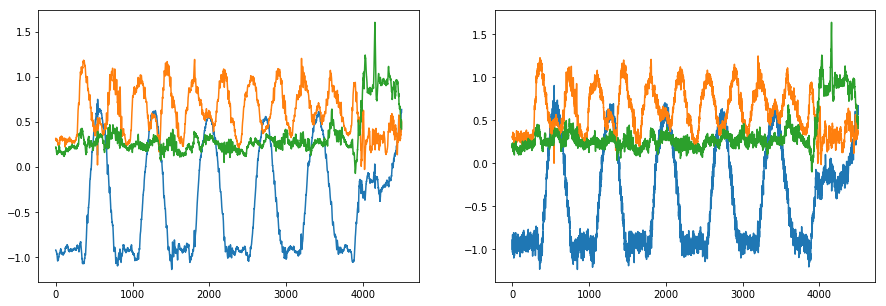

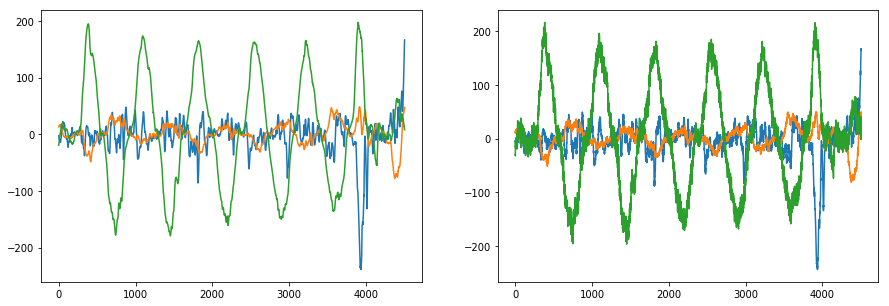

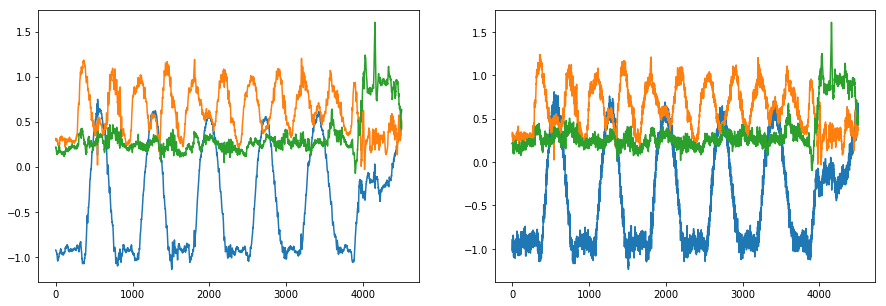

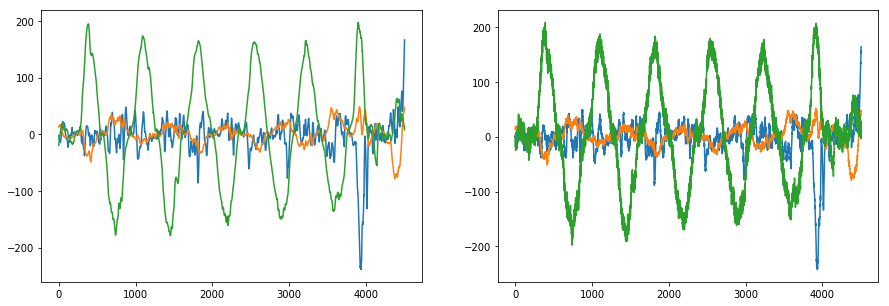

In [41]:
PD2 = PhysioData_SectionFeatures(num_sections=15,
                                 test_subject_ids=1,
                                 train_subject_ids=1,
                                 test_rep_nums=5,
                                 train_rep_nums=5,
                                 test_ex_abbrs=['RF'],
                                 train_ex_abbrs=['RF'],
                                 with_non_Ex=True,
                                 rot_axis_test_data=[0,0],
                                 rot_angle_test_data=[90,-90],
                                 add_noise_test_data=True,
                                 add_noise_train_data=True,
                                 snr_db=20,
                                 csv_data_dir='E:\Physio_Data_Split_Ex_and_NonEx',
                                 csv_skiprows=0,
                                 csv_separator=',',
                                 data_base_path='E:\Physio_Data\DataBase_Physio_with_nonEx.db',
                                 print_progress=True)

In [ ]:
PD2.get_X_train_df().head()

In [ ]:
PD2.get_X_test_df().head()